# 0-背景

用LSTM来做电影推荐系统

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/data/dev_tool/Anaconda2-5/envs/python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/dev_tool/Anaconda2-5/envs/python35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
dataset = pd.read_csv("raw_data/ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))

In [4]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# 用户数和电影数
print(len(dataset.user_id.unique()), len(dataset.item_id.unique()))
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

943 1682


In [6]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [7]:
# Train test split数据集划分。可以再分为训练集，校验集和测试集
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,user_id,item_id,rating,timestamp
46582,693,49,5,875730386
14016,398,174,3,882342669
65879,895,596,4,887159854
82536,801,216,3,875985767
39591,592,99,5,875658824


In [9]:
test.head()

,user_id,item_id,rating,timestamp
60588,698,128,4,878882667
96180,662,173,5,889493540
28442,453,489,2,888266754
98250,300,99,5,882074408
29718,188,96,4,893277579


# 方法1：矩阵分解


In [10]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


为此，需要学习到一个嵌入矩阵以表示movies和users,再对两者进行`dot product`。在预测用户对电影的评分时，拿单个用户和对应的电影进行相乘即可。
例如：当用户和电影的维度都是2维时候,用户嵌入矩阵每个维度表示含义：[该用户动作片喜欢程度，用户长电影的喜欢程度]，电影嵌入矩阵每个维度表示含义：
[这部电影动作元素多少，这部电影时长多少]。这样用户u对于电影m的评分可以计算如下：
$用户u喜欢动作片的程度×m电影动作片程度 + 用户u喜欢长电影程度 × m的时长$

模型通过迭代优化，在训练集的用户-电影评分中获取最小均方误差。


In [11]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

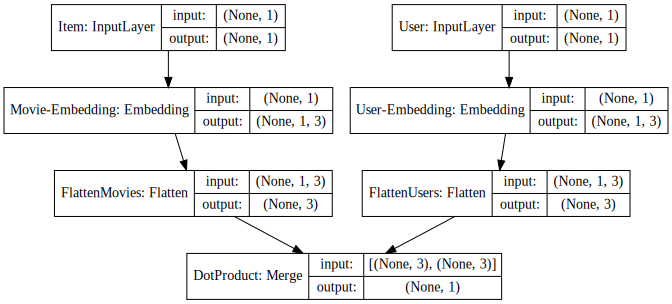

In [13]:
# 注意，
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

注意：
这里有些依赖：
```
yum install graphviz
yum install graphviz-dev
```

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [15]:
%%time
# 进行模型训练
history = model.fit([train.user_id, train.item_id], train.rating, epochs=100, verbose=0)

CPU times: user 6min 34s, sys: 1min 33s, total: 8min 8s
Wall time: 4min 28s


查看训练过程每轮的损失值：

Text(0,0.5,'Train Error')

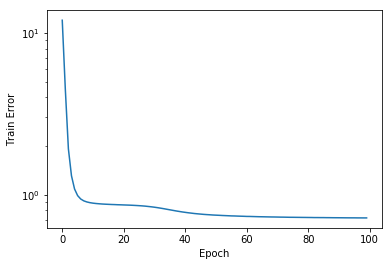

In [16]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

在预测的时候，我们会采用四舍五入的方式取整。一般实际中并不会这样处理，只是这里打分结果都是整数，所以就这样处理了。其实可以采用one-hot编码方式来对评分进行编码。

In [17]:
y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_true = test.rating

In [18]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_hat)

0.69135

MAE=0.69，结果还不错。如果再进一步做参数和超参数调整优化，可以进一步提升性能。这个后面再补充。

提取嵌入矩阵

In [19]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.891520,0.857434,1.002224
std,0.470536,0.538981,0.423689
min,-0.859310,-1.198049,-0.508080
25%,0.559874,0.463007,0.715369
50%,0.921561,0.881052,1.028888
75%,1.226215,1.266315,1.290787
max,3.034703,2.280423,2.558902


In [21]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,944.000000,944.000000,944.000000
mean,1.120411,1.159110,1.119424
std,0.531820,0.489049,0.486735
min,-0.628745,-0.762630,-1.341101
25%,0.785811,0.867777,0.809936
50%,1.113729,1.202229,1.114263
75%,1.464745,1.491464,1.433187
max,3.352219,2.875547,2.730635


从上述结果可以看出用户和电影的嵌入矩阵都存在负数。有时候后续的系统输入要求嵌入矩阵都是非负数，我们可以采用以下方式获取非负的嵌入矩阵。

# 2-Non-negative Matrix factorisation (NNMF) in Keras


这个代码与之前的差不多，只是在嵌入矩阵获取的时候添加了非负数的限制。

In [26]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input))

prod = keras.layers.merge([movie_vec, user_vec], mode='dot',name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

We now verify if we are indeed able to learn non-negative embeddings. I'll not compare the performance of NNMF on the test set, in the interest of space.
我们来看看是否真的能够学到非负的嵌入矩阵。

In [28]:
history_nonneg = model.fit([train.user_id, train.item_id], train.rating, epochs=10, verbose=0)

In [29]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,1683.000000,1683.000000,1683.000000
mean,0.839561,0.840075,0.838098
std,0.301144,0.300974,0.300052
min,-0.000000,-0.000000,-0.000000
25%,0.655499,0.659878,0.654167
50%,0.898050,0.898812,0.892779
75%,1.072557,1.074052,1.073370
max,1.367638,1.391874,1.361823


In [35]:
pd.DataFrame(movie_embedding_learnt).head()

,0,1,2
0,1.141340,1.125894,1.145409
1,0.966766,0.990233,1.012192
2,0.953209,0.927560,0.967681
3,1.056142,1.058076,1.100821
4,1.007808,1.060272,1.009017


In [36]:
none_neg_y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
none_neg_y_true = test.rating
mean_absolute_error(none_neg_y_true, none_neg_y_hat)

0.6863

In [37]:
none_neg_y_hat[:10]

array([[4.],
       [4.],
       [3.],
       [4.],
       [4.],
       [3.],
       [4.],
       [2.],
       [3.],
       [3.]], dtype=float32)

In [39]:
none_neg_y_true[:10]

60588    4
96180    5
28442    2
98250    5
29718    4
38670    3
20335    4
71058    2
26409    3
68103    4
Name: rating, dtype: int64

# 3- Neural networks for recommendation

与之前的矩阵分解模型不同的是神经网络模型将user和item嵌入矩阵进行连接，而不是之前的`dot product`操作。所以就可以学习到复杂的非线性模型。
此外user和item的嵌入矩阵维度可以不同。

In [40]:
n_latent_factors_user = 5
n_latent_factors_movie = 16
# 尝试调参

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge([movie_vec, user_vec], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

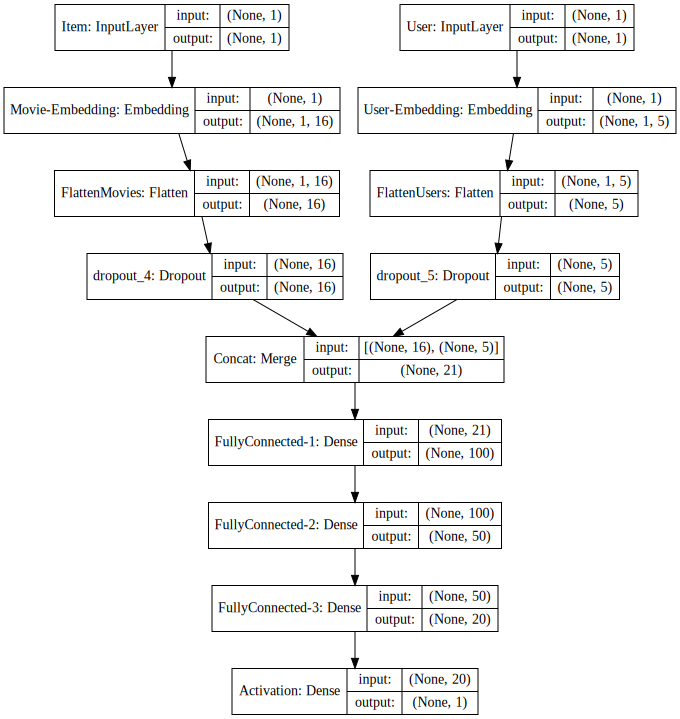

In [41]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 16)        26928       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         4720        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

可以看出神经网络参数数量是比矩阵分解更多。

In [43]:
%%time
history = model.fit([train.user_id, train.item_id], train.rating, epochs=250, verbose=0)

CPU times: user 37min 29s, sys: 10min 3s, total: 47min 33s
Wall time: 18min 48s


In [44]:
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.7043
0.7244044695734978


上述结果与之前的矩阵分解模型其实很接近，可能的原因是对于神经网络我们需要进一步调参。

## 神经网络调参

In [ ]:
尝试调整用户和电影嵌入矩阵的维度。
发现n_latent_factors_movie从8调整为16后，mean_absolute_error结果值是变大了。

参考资料：
https://nipunbatra.github.io/blog/2017/recommend-keras.html